# Home assignement 3: Stochastic models

This tutorial illustrates the manipulation of stochastic models and signals.

## Part 1: Processing and spectral analysis of Local Field Potentials
Local Field Potentials (LFPs) designate the "low" frequency part of the electrical potential in the extracellular medium of the brain, typically below 200Hz. It reflects many network processes, and is assumed to be generated, to a large extended, by post-synaptic currents entering the neurons.

Let us load some exemplary data recoded from the macaque hippocampus that you can dowload from https://owncloud.tuebingen.mpg.de/index.php/s/REc82bzpCetG27T (update the dataPath variable below before loading). The variable ```LFP``` will store the LFP time series, ```dt``` the sampling period, and ```t``` the associated time axis.

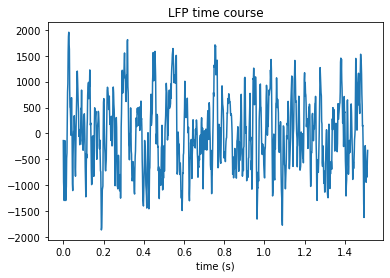

In [1]:
# # to display all outputs of a cell
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

# load local field potential
dataPath = './'
from scipy import io
import numpy as np
import matplotlib.pyplot as plt

lfpdat = io.loadmat("LFPdat.mat")

# Define LFP time series
LFP = lfpdat['LFP'][:,0]
# Define sampling period dt (sampling frequency is 660Hz)
dt = lfpdat['dt'][:,0]
t = np.arange(LFP.shape[0])*dt

# we plot only the begining of the recording
plt.plot(t[0:1000],LFP[0:1000])
plt.title('LFP time course')
plt.xlabel('time (s)')
plt.show()

We want to estimate the Power Spectral Density of the LFP signal. We use the scipy.signal.welch function for this purpose. 

In [2]:
from scipy.signal import welch
help(welch)

Help on function welch in module scipy.signal._spectral_py:

welch(x, fs=1.0, window='hann', nperseg=None, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1, average='mean')
    Estimate power spectral density using Welch's method.
    
    Welch's method [1]_ computes an estimate of the power spectral
    density by dividing the data into overlapping segments, computing a
    modified periodogram for each segment and averaging the
    periodograms.
    
    Parameters
    ----------
    x : array_like
        Time series of measurement values
    fs : float, optional
        Sampling frequency of the `x` time series. Defaults to 1.0.
    window : str or tuple or array_like, optional
        Desired window to use. If `window` is a string or tuple, it is
        passed to `get_window` to generate the window values, which are
        DFT-even by default. See `get_window` for a list of windows and
        required parameters. If `window` is arr

This function cuts the input time series in overalpping segments, computes the squared Fourier transform of each to estimate the periodogram by averaging, as seen in the lecture. 

First, let us use a deterministic continuous time model: we assume continuous time signal $x(t)$ is analyzed spectrally on a finite duration interval $[-T/2,T/2]$ by computing the squared Fourier transform of the pointwise product of $x(t/T)$, using a tappering window $w(t)$ such that $w(t)=0$ for $|t|>1/2$. 

**Important: plot all periodograms with a physical frequency axis (Hz)**

**Question 1:**
 - (a) (2 points) Compute the analytical expression of the continuous time Fourier transform of the pointwise product $$
 \frac{1}{T}{x(t)\cdot w(t/T)}\,,
 $$ 
 as a function of $T$ and the Fourier transforms of $x$ and $w$.

$$x(t)\stackrel{FT}{\longrightarrow}\hat{x}(f);w(t)\stackrel{FT}{\longrightarrow}\hat{w}(f)\\
w(t/T)\stackrel{FT}{\longrightarrow}\int_{-\infty}^{\infty}w(t/T)e^{-i2\pi ft}dt=T\int_{-\infty}^{\infty}w(t/T)e^{-i2\pi ft/T}d(t/T)=T\hat{w}(Tf)\\
\frac{1}{T}x(t)\cdot w(t/T)\stackrel{FT}{\longrightarrow}\frac{1}{T}\hat{x}(f)*T\hat{w}(Tf)=\hat{x}(f)*\hat{w}(Tf)$$

 
 - (b) (2 points) What is the limit of this function for $T$ very small and $T$ very large? Justify qualitatively or using distributions.

1)
$$T\rightarrow0, w(t/T)\rightarrow\delta(t),\hat{w}(Tf)\rightarrow1(f)\\
\therefore\frac{1}{T}x(t)\cdot w(t/T)\stackrel{FT}{\longrightarrow} \int^{\infty}_{-\infty}\hat{x}(f)df$$
when T is very small, the amplitude for each freq is same. </br>
when fft been conducted, if window is too small, the kernel wont be freq-selective. (as figure below)</br>
2)
$$T\rightarrow\infty, t/T\rightarrow0, w(t/T)\rightarrow1(t),\hat{w}(f)\rightarrow\delta(f)\\
\therefore\frac{1}{T}x(t)\cdot w(t/T)\stackrel{FT}{\longrightarrow}\frac{1}{T}\hat{x}(f)$$
when T is very big, the pattern of spectrogram totally depends on x, but the amplitude is very low. </br>

 - (c) (2 points) The "nperseg" controls the width (number of points of the segments) used by the algorithm to compute a single DFT (with the FFT algorithm), proportional to $T$ in the continuous time model. Compute and plot the periodogram of the LFP signal for $T=1s$. What is the dominant frequency in this signal?

The dominant freq is 10.00 Hz


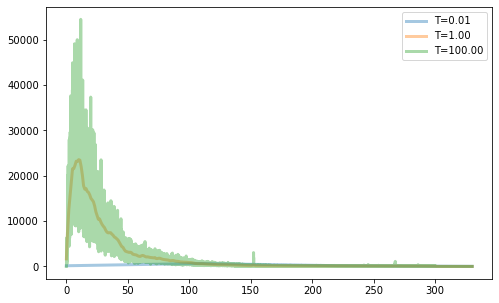

In [5]:
fs = int(1/dt[0])
plt.figure(figsize=(8,5))
for T in [0.01,1,100]:
    f, pxx = welch(LFP,fs,nperseg=T/dt)
    plt.plot(f,pxx,label='T=%.2f'%T,alpha=.4,linewidth=3)
    if T==1:
        print('The dominant freq is %.2f Hz' %f[np.argmax(pxx)])
plt.legend()
plt.show()


 - (d) (2 points) The time resoved power in the so called gamma band (typically between 60 and 120Hz) of the LFP has been reported to reflect the amount of recurrent activity in the network, and is related to the BOLD signal measured in fMRI (see part 3). Perform the following operations to extract this time resolved power: 
   - filter the LFP in the [60,120Hz] band with a Butterworth filter to obtain signal $g$ (use scipy.signal.filtfilt to apply a zero phase filter), 
   - take the square of $g$, $g^2$, 
   - low pass filter $g^2$ below $60Hz$ to get $g_{pow}$ the time resolved gamma power. 
   For each signal (LFP,$g$ ,$g^2$,$g_{pow}$), estimate the PSD with the Welch periodogram and plot it, using $T=1s$

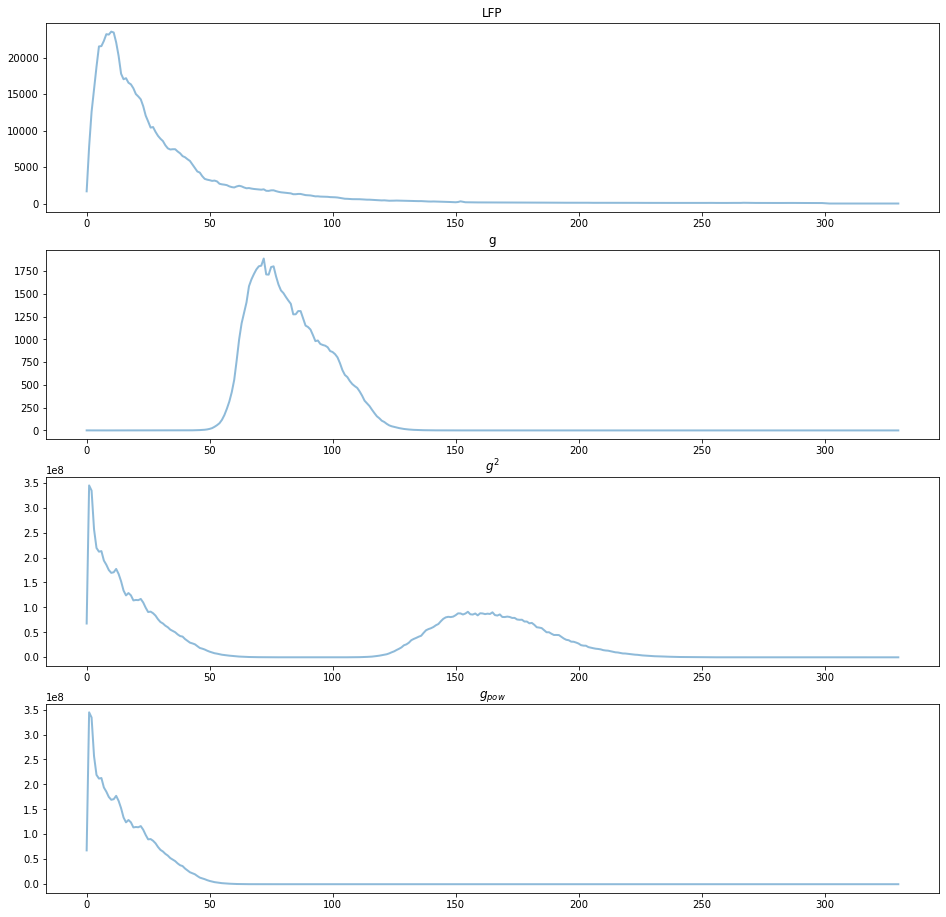

In [26]:
from scipy.signal import filtfilt, butter

b, a = butter(3, np.array([60, 120]), 'bandpass', False, 'ba', fs=fs) 
g = filtfilt(b, a, LFP)
g_square = g**2
b, a = butter(3, 60, 'low', False, 'ba', fs=fs) 
g_pow = filtfilt(b, a, g_square)

T = 1
fig,axes = plt.subplots(4,1,figsize=(16,16))
signals = {'LFP':LFP,'g':g,'$g^2$':g_square,'$g_{pow}$':g_pow}
for i,signal in enumerate(signals.keys()):
    f, pxx = welch(signals[signal],fs,nperseg=T/dt)
    axes[i].plot(f,pxx,alpha=.5,linewidth=2)
    axes[i].set_title('%s'%signal)
plt.show()


 - (d) (2 points) Given that the periodogram reflects (to some extent, see lecture) the expected squared modulus of the Fourier transform of signal realisations, justify qualitatively the shape taken by the successive PSDs (why particular frequencies appear or are preserved/removed...).

### fig2
LFP$\stackrel{60-12Hz}{\longrightarrow} g$: bandpass filter only keeped signal from 60~120Hz, thus only left one peak (~70Hz).  </br>
### fig3
$g\stackrel{auto-correlation}{\longrightarrow}g^2$: left two peaks (~0Hz & ~160Hz)</br>
 because $g^2=\sum_{-\infty}^{\infty}c_ne^{i2\pi f_nt}\sum_{-\infty}^{\infty}c_me^{i2\pi f_mt}=\sum_{-\infty}^{\infty}\sum_{-\infty}^{\infty} c_n*c_m e^{i2\pi f_nt+i2\pi f_mt}=\sum_{-\infty}^{\infty}\sum_{-\infty}^{\infty} c_n*c_me^{i2\pi (f_n+f_m) t}$</br>
$\because c_n, c_m \neq 0, (60Hz<|f_n|,|f_m|<120Hz), \therefore c_{g^2} \neg 0, (0Hz<|f_n+f_m|<60Hz; 120Hz<|f_n+f_m|<240Hz)$</br>
### fig4
$g^2\stackrel{<60Hz}{\longrightarrow}g_{pow}$: lowpass filter only allowed signal<60Hz, thus filtered out the peak ~160Hz. 



 - (e) Plot the square root of $g_{pow}$ on a short interval (1s) and check visually it follows the enveloppe of oscillations in $g$ correctly.

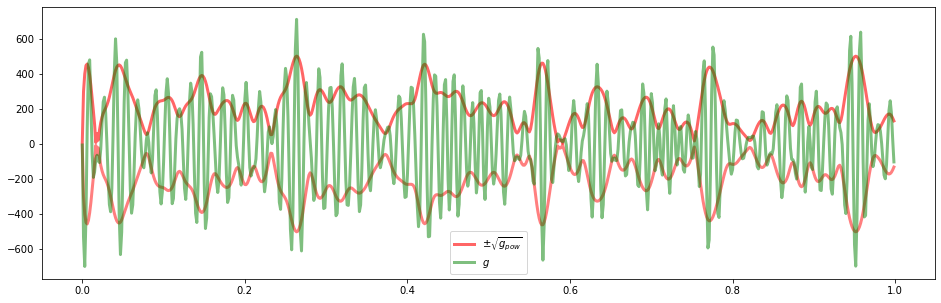

In [45]:
g_root = np.sqrt(abs(g_pow))
plt.figure(figsize=(16,5))
plt.plot(t[0:int(1/dt)],g_root[0:int(1/dt)],label='$\pm\sqrt{g_{pow}}$',alpha=.6,linewidth=3,color='red')
plt.plot(t[0:int(1/dt)],-g_root[0:int(1/dt)],alpha=.5,linewidth=3,color='red')
plt.plot(t[0:int(1/dt)],g[0:int(1/dt)],label='$g$',alpha=.5,linewidth=3,color='green')
plt.legend()
plt.show()

 - (f) (2 points) The phase of $g(t)$ has been hypothesized to be important for organizing neural computation, in order to extract this information, compute the analytic signal associated to $g$ using the scipy.signal.hilbert function. Plot the trajectory of the analytic signal in the complex plane on a short interval of 1s, check visually that the vector operates regular rotations around the origin. Plot the argument of the analytic signal as a function of time: check visually that the values are compuatible with an interpretation as the phase of the original oscillatory signal $g(t)$.
 
 

In [53]:
from scipy.signal import hilbert
from numpy import imag, real

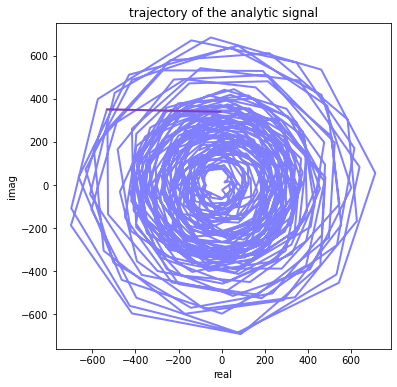

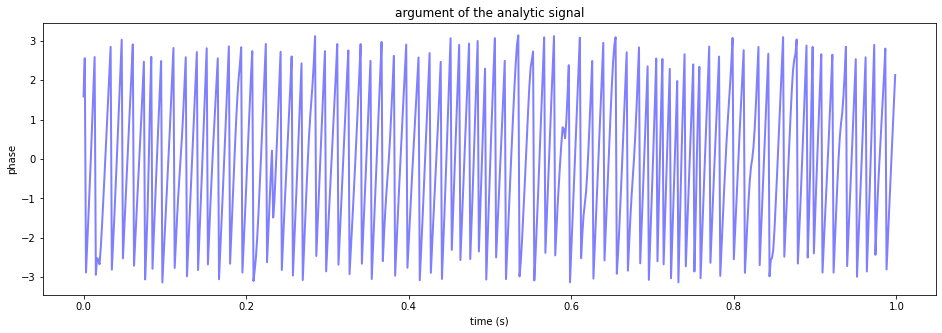

In [79]:
g_trajectory = hilbert(g)
plt.figure(figsize=(6,6))
plt.plot(real(g_trajectory[0:2]),imag(g_trajectory[0:2]), 'red',alpha=.5,linewidth=2)
plt.plot(real(g_trajectory[0:int(1/dt)]),imag(g_trajectory[0:int(1/dt)]),'blue',alpha=.5,linewidth=2)
plt.xlabel('real')
plt.ylabel('imag')
plt.title('trajectory of the analytic signal')
plt.show()
plt.show()

plt.figure(figsize=(16,5))
plt.plot(t[0:int(1/dt)],np.angle(g_trajectory[0:int(1/dt)]),'blue',alpha=.5,linewidth=2)
plt.xlabel('time (s)')
plt.ylabel('phase')
plt.title('argument of the analytic signal')
plt.show()

